<a href="https://colab.research.google.com/github/Ashraf-Saleheen/For-Upwork/blob/main/Sentiment_Analysis_%26_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Figure size 1200x800 with 0 Axes>

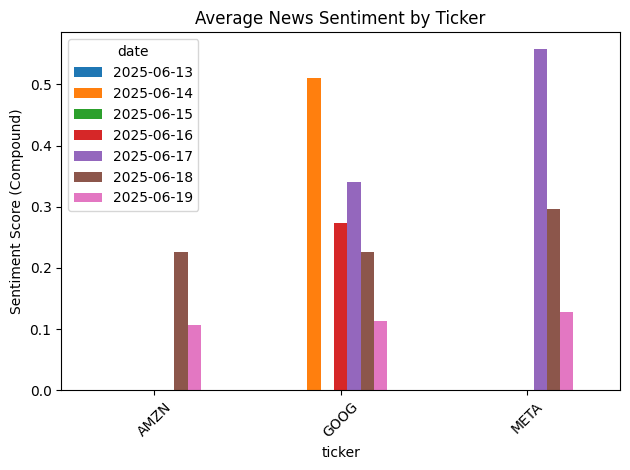

date    2025-06-13  2025-06-14  2025-06-15  2025-06-16  2025-06-17  \
ticker                                                               
AMZN           NaN         NaN         NaN         NaN      0.0000   
GOOG           0.0      0.5106         0.0      0.2732      0.3400   
META           NaN         NaN         NaN      0.0000      0.5574   

date    2025-06-18  2025-06-19  
ticker                          
AMZN        0.2263    0.107432  
GOOG        0.2263    0.113486  
META        0.2960    0.127554  


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime, date
import nltk
import time
import random

# Initialize NLTK VADER
nltk.download('vader_lexicon', quiet=True)
vader = SentimentIntensityAnalyzer()

# Configure parameters
tickers = ['AMZN', 'GOOG', 'META']
news_tables = {}
base_url = 'https://finviz.com/quote.ashx?t='

# Realistic browser headers
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'
}


def parse_finviz_date(date_str):
    """Handle Finviz's date formats including 'Today' and empty strings"""
    if not date_str or date_str.strip() == '':
        return date.today()
    if date_str == 'Today':
        return date.today()
    try:
        if len(date_str.split('-')) == 3:
            return datetime.strptime(date_str, '%b-%d-%y').date()
        return datetime.strptime(date_str + f'-{datetime.now().year}', '%b-%d-%Y').date()
    except ValueError:
        return date.today()


# Scrape news data with error handling
for ticker in tickers:
    try:
        url = base_url + ticker
        req = Request(url=url, headers=headers)
        time.sleep(random.uniform(1, 3))  # Rate limiting

        with urlopen(req) as response:
            # Explicitly specify html.parser to avoid warning
            html = BeautifulSoup(response, 'html.parser')
            news_table = html.find(id='news-table')

            if news_table:
                news_tables[ticker] = news_table
            else:
                print(f"No news table found for {ticker}")
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")

# Parse and process data
parse_data = []

for ticker, news_table in news_tables.items():
    for row in news_table.find_all('tr'):  # Using find_all instead of deprecated findAll
        try:
            # Safely extract title
            title = row.a.get_text(strip=True) if row.a else "No title"

            # Safely extract date/time - Finviz stores this in the first td with align=right
            td = row.find('td', align='right')
            if td:
                date_text = td.get_text(strip=True)
                date_parts = date_text.split()

                if len(date_parts) == 1:
                    date_str = 'Today' if date_parts[0] == 'Today' else datetime.now().strftime('%b-%d-%y')
                    time_str = None if date_parts[0] == 'Today' else date_parts[0]
                else:
                    date_str = ' '.join(date_parts[:-1])
                    time_str = date_parts[-1]

                parsed_date = parse_finviz_date(date_str)
                parse_data.append([ticker, parsed_date, time_str, title])
        except Exception as e:
            print(f"Error processing row: {str(e)}")

if parse_data:
    df = pd.DataFrame(parse_data, columns=['ticker', 'date', 'time', 'title'])

    # Convert dates that might have slipped through
    df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date
    df = df.dropna(subset=['date'])  # Remove rows with invalid dates

    # Sentiment analysis
    df['compound'] = df['title'].apply(lambda x: vader.polarity_scores(x)['compound'])

    # Visualization
    plt.figure(figsize=(12, 8))
    mean_df = df.groupby(['ticker', 'date'])['compound'].mean().unstack()
    mean_df.plot(kind='bar', rot=45)
    plt.title('Average News Sentiment by Ticker')
    plt.ylabel('Sentiment Score (Compound)')
    plt.tight_layout()
    plt.show()

    print(mean_df)
else:
    print("No data was scraped. Possible reasons:")
    print("- Finviz is blocking your requests (try changing IP or using proxies)")
    print("- The page structure has changed (inspect the HTML manually)")
    print("- Check your internet connection")